# Training a counterfactually fair CAD model





## Counterfactual Fairness

Attempts to mitigate bias in a model by simply removing sensitive attributes from its training, i.e. fairness by unawareness, often fails due to bias 'leaking' through causal relationships between the sensitive attribute and other features retained in the data. The counterfactual fairness approach introduced by Kusner et al. (2017, in Advances in Neural Information Processing Systems, https://proceedings.neurips.cc/paper_files/paper/2017/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf) addresses this limitation by deconvoluting the biased observed variables into a fair set of unbiased latent variables. It allows the model to only learn from information that is independent from the protected attribute, and neutralise both direct and proxy bias pathways.

### Notations and definitions

we adopt the following notations consistent with the Pearlian causal framework used by Kusner et al.:

- $S$ **Protected attribute**: The sensitive variable we wish to be fair toward
- $X$ **Observed features**: The set of features available in the dataset (e.g. Blood Pressure, Cholesterol)
- $U$ **Latent (unobserved) variables**: Unobserved variables that are independent of the protected attribute $A$
- $Y$ **Target**: The outcome we are predicting (e.g. Presence of CAD)
- $Y_{S \leftarrow s}$: The value of $Y$ under a counterfactual intervention where $S$ is set to $s$
- $M = (U, V, F)$ a causal model corresponding to the observed data, where $V \equiv X \cup Y \cup S$, and $F$ is the set of structural equations of the model

**Counterfactual Fairness:** A predictor $\hat{Y}$ is counterfactually fair if, for a specific individual, the probability distribution of the prediction is the same in the actual world as it would be in a counterfactual world where their protected attribute (e.g., Sex) was different.

Formally, for any value $a'$ of the protected attribute $A$:$$P(\hat{Y}_{S \leftarrow s} = y \mid X=x, S=s) = P(\hat{Y}_{S \leftarrow s'} = y \mid X=x, S=s')$$

---

## The experiment

Using the fairness-unaware models trained to predict Cardiovascular Disease in Straw et al. (2024, doi: [10.2196/46936](https://doi.org/10.2196/46936)) as baseline models, we will apply the fairness algorithm proposed by Kusner et al. to train a fair CAD predictor.

### The target bias
While Kusner focus on mitigating bias on tasks where the protected attribute should have no influence on the target outcome (e.g. sex and exam results), the clinical domain brings a new challenge. Indeed, protected attributes such as sex or race often encompass two variables: the clinically relevant biological attribute which can cause a disease to present differently across individuals, and the sociological attribute which has societal factors that can influence healthcare access, physician perception, diagnosis and care. A clinical outcome might be influenced by the former but should remain independent of the latter.

If we aim for fairness based on the high-level sex attribute, we risk removing legitimate clinical signals and degrading diagnostic accuracy. Therefore, our objective in experiment is to make the model counterfactually fair with regards to **sociological sex**.

### Hypothesis

By using counterfactual inference to model latent variables that are independent of the protected attribute, we can build a predictor that satisfies counterfactual fairness (i.e. ensuring that an individual’s predicted risk of CAD remains invariant to their sociological sex), while maintaining clinically acceptable predictive performance and reducing the False Negative Rate (FNR) disparity observed in baseline models.

## Library imports

In [1]:
try:
  from google.colab import userdata
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
except ImportError:
  PROJECT_ROOT = '/'

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm

from google.colab import output
# output.enable_custom_widget_manager()
output.disable_custom_widget_manager()

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1)

## Function library

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold,\
 StratifiedGroupKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,\
 recall_score, roc_auc_score
from scipy.stats import sem, t

def train_random_forest(X_train, y_train, X_test, y_test):
  '''
    Trains a sklearn RandomForestClassifier on the given training data,\
     optimised hyperparameters with 3-fold GridSearchCV

     Inputs:
       X_train: training features
       y_train: training labels
       X_test: test features
       y_test: test labels

     Outputs:
       rf: trained RandomForestClassifier
       y_pred: predicted labels
       y_pred_proba: predicted probabilities
  '''
  param_grid = {
    "n_estimators": [100],
    "max_depth": [5, 10, 20, None],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
  }

  #create the RF classifier
  rf = RandomForestClassifier()

  #create the grid search
  rf_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                               n_iter=10, scoring='roc_auc',
                               cv=3, n_jobs=-1, random_state=42)

  #fit the grid search
  rf_search.fit(X_train, y_train)
  y_pred = rf_search.predict(X_test)
  y_pred_proba = rf_search.predict_proba(X_test)[:,1]

  return [rf_search, y_pred, y_pred_proba]

def get_perf_metrics(y_true, y_pred, y_pred_proba):
  '''
    Calculates the performance metrics for a given set of predictions.

    Inputs
      y_true: true labels
      y_pred: predicted labels
      y_pred_proba: predicted probabilities

    Outputs
      accuracy: accuracy score
      roc_auc: ROC AUC (Receiver Operating Characteristic Area Under the Curve)
      FNR: False Negative Rate
      FPR: False Positive Rate
      tn: True Negatives
      fp: False Positives
      fn: False Negatives
      tp: True Positives
  '''
  accuracy = accuracy_score(y_true, y_pred)
  roc_auc = roc_auc_score(y_true, y_pred_proba)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  FNR = fn / (fn + tp)
  FPR = fp / (fp + tn)

  return [accuracy, roc_auc, FNR, FPR, tn, fp, fn, tp]

def get_95_ci(data):
  '''
    Calculates the 95% confidence interval for a given set of data.

    Inputs
      data: data as a Pandas Series

    Outputs
      interval: Array of the lower and upper bounds of the confidence interval
  '''
  n = len(data)
  mean = data.mean()
  std_err = sem(data)
  interval = t.interval(0.95, n - 1, loc=mean, scale=std_err)
  return interval

def run_sex_classifier(features, target_sex):
  '''
    Trains a Random Forest classifier on the given features\
     to predict the target sex.

    Inputs
      features: Pandas DataFrame of features
      target_sex: target sex to predict

    Outputs
      roc_auc: ROC AUC (Receiver Operating Characteristic Area Under the Curve)
  '''
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
  audit_rf = RandomForestClassifier(
      n_estimators=100,
      max_depth=5,
      random_state=4
  )
  scores = cross_val_score(audit_rf, features, target_sex, cv=cv, scoring='roc_auc')
  return scores.mean(), scores.std()

def run_grouped_sex_classifier(features, target_sex, group):
  '''
    Trains a Random Forest classifier on the given features,\
     to predict the target sex, respecting the data groups\
     to avoid data leakage.

    Inputs
      features: Pandas DataFrame of features
      target_sex: target sex to predict
      group_col: group column

    Outputs
      roc_auc: ROC AUC (Receiver Operating Characteristic Area Under the Curve)
  '''
  cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=4)
  audit_rf = RandomForestClassifier(
      n_estimators=100,
      max_depth=5,
      random_state=4
  )
  scores = cross_val_score(audit_rf, features, target_sex, cv=cv,
                           scoring='roc_auc', groups=group)
  return scores.mean(), scores.std()

## Data preparation

In [4]:
heart_disease = pd.read_csv(f'{PROJECT_ROOT}data/heart_disease_cleveland_hungary.csv')

# Remove duplicates and null values, as per Straw et al.

rows_to_drop  = (heart_disease['ST slope'] == 0) | (heart_disease['cholesterol'] == 0) | (heart_disease['resting bp s'] == 0) | (heart_disease.duplicated(keep='first'))
heart_disease.drop(heart_disease[rows_to_drop].index, inplace=True)

heart_disease.rename(columns={'sex':'sex', 'chest pain type':'cp', 'resting bp s':'bp', 'cholesterol':'chol',
                              'fasting blood sugar':'fbs', 'resting ecg':'ecg', 'max heart rate':'mhr', 'exercise angina':'ang',
                              'oldpeak':'st', 'ST slope':'slope', 'target':'cvd'}, inplace=True)

# Clip negative values of st (oldpeak)
heart_disease['st'] = heart_disease['st'].clip(lower=0)

# Z-score for age and mhr
cont_variables = ['mhr', 'age']
for var in cont_variables:
  heart_disease[var] = (heart_disease[var] - heart_disease[var].mean()) / heart_disease[var].std()

# Scaling for chol
log_chol = np.log(heart_disease['chol'])
heart_disease['chol_scaled'] = (log_chol - log_chol.mean()) / log_chol.std()

# Scaling for BP
log_bp = np.log(heart_disease['bp'])
heart_disease['bp_scaled'] = (log_bp - log_bp.mean()) / log_bp.std()

# Indexing cp and slope at 0
heart_disease['cp'] = heart_disease['cp'] - 1
heart_disease['slope'] = heart_disease['slope'] - 1

heart_disease.reset_index(drop=True, inplace=True)
heart_disease.describe()



,age,sex,cp,bp,chol,fbs,ecg,mhr,ang,st,slope,cvd,chol_scaled,bp_scaled
count,7.450000e+02,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,7.450000e+02,745.000000,745.000000,745.000000,745.000000,7.450000e+02,7.450000e+02
mean,-2.861246e-16,0.755705,2.163758,133.000000,244.702013,0.166443,0.640268,5.340992e-16,0.385235,0.902953,0.589262,0.476510,2.279459e-15,4.603029e-15
std,1.000000e+00,0.429957,0.956037,17.283142,59.165249,0.372728,0.838900,1.000000e+00,0.486978,1.072953,0.598288,0.499783,1.000000e+00,1.000000e+00
min,-2.618103e+00,0.000000,0.000000,92.000000,85.000000,0.000000,0.000000,-2.903068e+00,0.000000,0.000000,0.000000,0.000000,-4.379780e+00,-2.822410e+00
25%,-7.225862e-01,1.000000,1.000000,120.000000,208.000000,0.000000,0.000000,-7.432164e-01,0.000000,0.000000,0.000000,0.000000,-5.737713e-01,-7.413101e-01
50%,1.198656e-01,1.000000,2.000000,130.000000,237.000000,0.000000,0.000000,-9.681997e-03,0.000000,0.500000,1.000000,0.000000,-1.865294e-02,-1.143818e-01
75%,6.463981e-01,1.000000,3.000000,140.000000,275.000000,0.000000,1.000000,8.053562e-01,1.000000,1.500000,1.000000,1.000000,6.138240e-01,4.660633e-01
max,2.541915e+00,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,2.516936e+00,1.000000,6.200000,2.000000,1.000000,3.953099e+00,3.259692e+00


## Data exploration

### Distributions

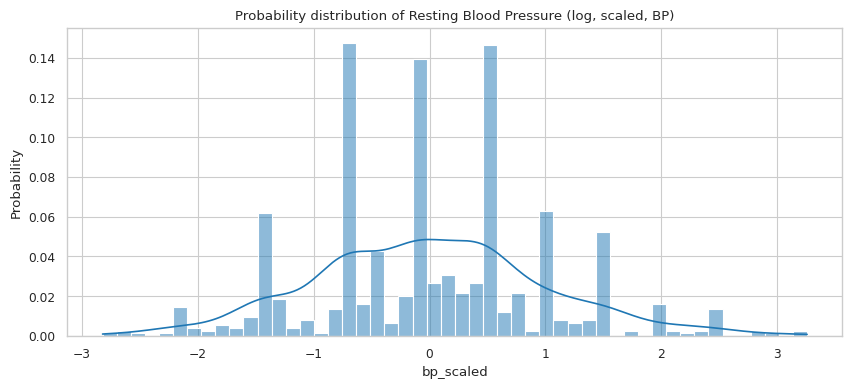

In [ ]:
# BP distribution
plt.figure(figsize=(10, 4))
sns.histplot(heart_disease, x='bp_scaled', bins=50, kde=True, stat='probability')
plt.title('Probability distribution of Resting Blood Pressure (log, scaled, BP)')
plt.show()

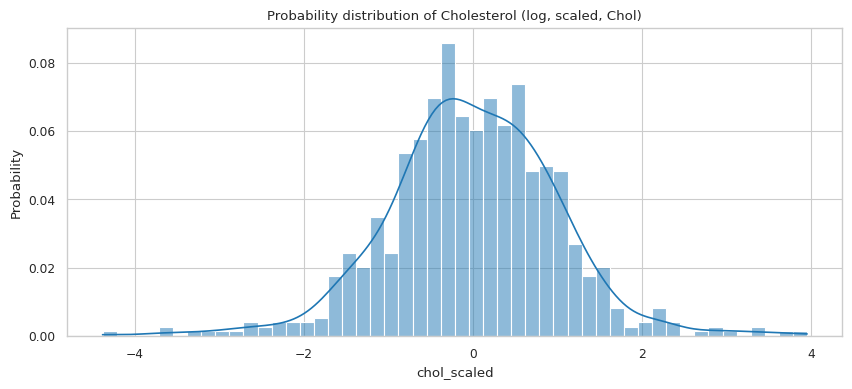

In [ ]:
# Chol distribution
plt.figure(figsize=(10, 4))
sns.histplot(heart_disease, x='chol_scaled', bins=50, kde=True, stat='probability')
plt.title('Probability distribution of Cholesterol (log, scaled, Chol)')
plt.show()

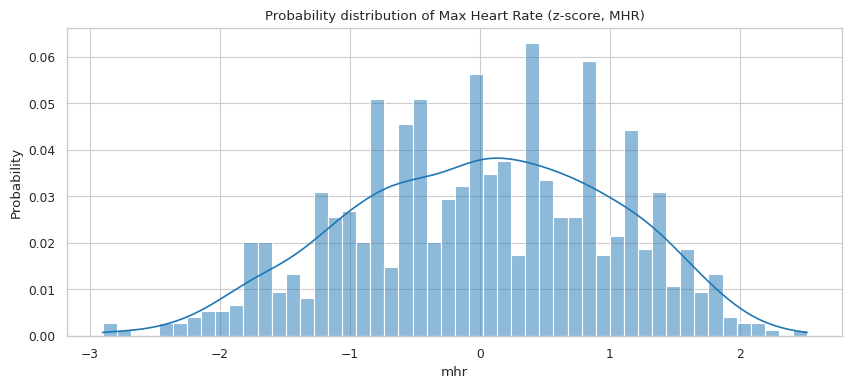

In [ ]:
# MHR distribution
plt.figure(figsize=(10, 4))
sns.histplot(heart_disease, x='mhr', bins=50, kde=True, stat='probability')
plt.title('Probability distribution of Max Heart Rate (z-score, MHR)')
plt.show()

### Relationships in data

We explore the statistical association between the clinical features and the target outcome, sex and age respectively. This will help us parameterise our causal model.

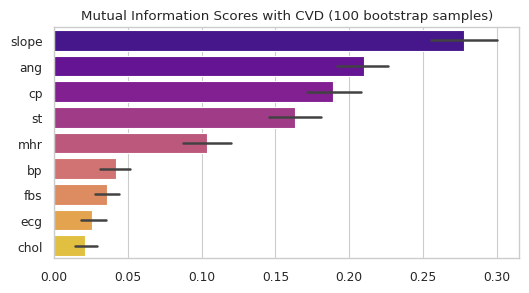

In [5]:
# Mutual information of clinical features with CVD
from sklearn.feature_selection import mutual_info_regression
from sklearn.utils import resample
X = heart_disease.drop(['cvd', 'age', 'sex', 'chol_scaled', 'bp_scaled'], axis=1)
y = heart_disease['cvd']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', estimator='mean', palette='plasma')
plt.title('Mutual Information Scores with CVD (100 bootstrap samples)')
plt.show()

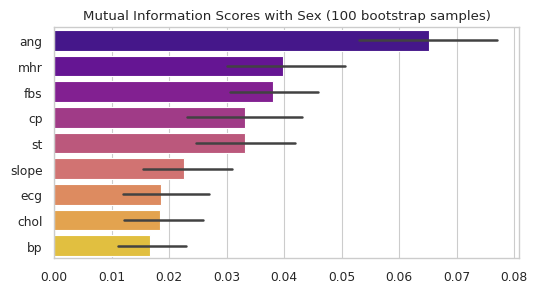

In [ ]:
# Mutual information of clinical features with Sex
X = heart_disease.drop(['cvd', 'age', 'sex', 'chol_scaled', 'bp_scaled'], axis=1)
y = heart_disease['sex']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores with Sex (100 bootstrap samples)')
plt.show()

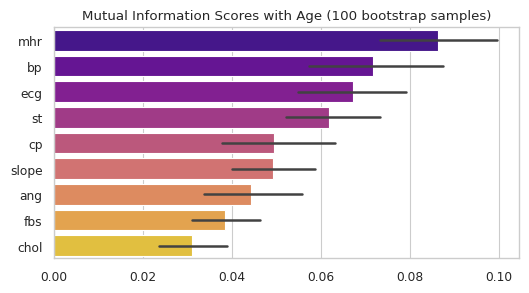

In [ ]:
# Mutual information of clinical features with Age
X = heart_disease.drop(['cvd', 'age', 'sex', 'chol_scaled', 'bp_scaled'], axis=1)
y = heart_disease['age']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores with Age (100 bootstrap samples)')
plt.show()

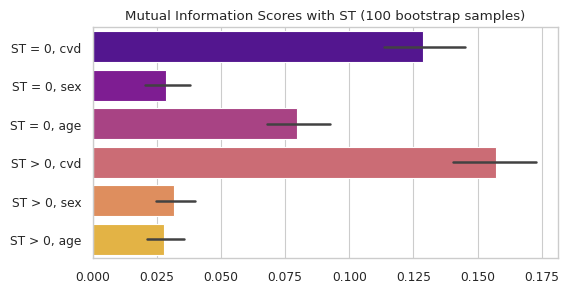

In [ ]:
# Mutual information of ST with CVD, Sex and Age
N_MI = 100

# We decompose ST into two components: a binary feature zero_ct (True if ST=0),
# and for patients with zero_ct = False, non_zero_ct with takes non-null values of ST
zero_st = heart_disease['st'] == 0
X_zero = heart_disease[['cvd','sex','age']]
y_zero = zero_st

X_non_zero = heart_disease.loc[heart_disease['st'] > 0, ['cvd','sex','age']]
y_non_zero = heart_disease.loc[heart_disease['st'] > 0, 'st']

mi_results = []

for i in range(N_MI):
  X_zero_resampled, y_zero_resampled = resample(X_zero, y_zero, n_samples=50, random_state=i)
  mi_scores_zero = mutual_info_regression(X_zero_resampled, y_zero_resampled, n_neighbors=5, random_state=4)
  X_non_zero_resampled, y_non_zero_resampled = resample(X_non_zero, y_non_zero, n_samples=50, random_state=i)
  mi_scores_non_zero = mutual_info_regression(X_non_zero_resampled, y_non_zero_resampled, n_neighbors=5, random_state=4)
  mi_scores = np.concatenate([mi_scores_zero, mi_scores_non_zero])
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=['ST = 0, cvd', 'ST = 0, sex', 'ST = 0, age',
                    'ST > 0, cvd', 'ST > 0, sex', 'ST > 0, age'])

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores with ST (100 bootstrap samples)')
plt.show()




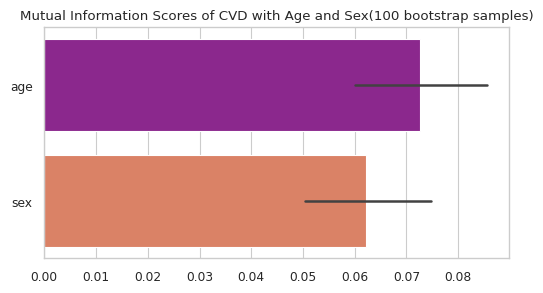

In [ ]:
# Mutual information of CVD with Age and Sex
X = heart_disease[['age', 'sex']]
y = heart_disease['cvd']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores of CVD with Age and Sex(100 bootstrap samples)')
plt.show()

---

## Causal modelling

From the feature set observed in the [Heart Disease (CAD) dataset](https://ieee-dataport.org/open-access/heart-disease-dataset-comprehensive), using clinical knowledge in the literature and strong assumptions, we create a causal model that we will use to:
1. Test the counterfactual fairness of the baseline predictive model
2. Create a counterfactually fair predictive model

### Causal assumptions

We hypothesise that clinical features in the CAD dataset are manifestations of a patient's **Age- and Sex-independent Physiological Integrity**, which we define as our fair latent variable $U$. It is independent of the protected attributes $S_{bio}$ and $S_{soc}$.

We postulate that subjective symptoms and clinician-dependent interpretations are influenced by Sociological Sex ($S_{soc}$). This creates an unfair pathway where the recorded value of a feature is not solely a manifestation of the patient's physiological state, but is also a product of external factors:
- Reporting bias: how a patient describes symptoms like chest pain based on gendered expectations
- Diagnostic bias: how a clinician interprets those symptoms, potentially mislabeling 'atypical' presentations in women

We assume that objective biomarkers such as cholesterol, maximum heart rate, resting blood pressure, fasting blood sugar, and measurements related to the ECG ST slope, are only influenced by the **biological sex** ($S_{bio}$), and are therefore fair pathways for the predictor.

Age is considered as the sole independent variable from $S_{bio}$ and $S_{soc}$.

**Structural equations:**

| Feature | Variable name | Variable type | Model distribution |
|:---|:---|:---|:---|
|Chest Pain Type | $CP$|Categorical|Categorical|
|Exercise Induced Angina | $Ang$|Binary|Bernoulli|
|Resting ECG Result | $ECG$|Categorical|Categorical|
|Max Heart Rate |$MHR$ |Numerical| Normal |
|Fasting Blood Sugar |$FBS$ |Binary|Bernoulli|
|Oldpeak |$ST$ |Numerical| Zero-Inflated Log-Normal |
|ST Slope |$Slope$ |Categorical|Categorical|
|Resting Blood Pressure | $BP$|Numerical| Log-Normal |
|Serum Cholesterol | $Chol$ |Numerical| Log-Normal |
|Age- and Sex-independent Physiological Integrity | $U$|Numerical| Normal |
|Cardiovascular Disease (target outcome) | $Y$|Binary|Bernoulli|

<br>

- $CP = f_{CP}(U, S_{soc}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{CP} + \beta_{CP, U}U + \beta_{CP,S_{soc}}S_{soc} + \beta_{CP,Age}Age))$

- $Ang = f_{Ang}(U, S_{soc}, Age) \sim  \text{Bernoulli}(\text{invlogit}(\alpha_{Ang} + \beta_{Ang, U}U + \beta_{Ang,soc}S_{soc} + \beta_{Ang,Age}Age))$

- $ECG = f_{ECG}(U, S_{soc}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{ECG} + \beta_{ECG, U}U + \beta_{ECG,soc}S_{soc} + \beta_{ECG,Age}Age))$

- $MHR = f_{MHR}(U, S_{bio}, Age) \sim \mathcal{N}(\alpha_{MHR} + \beta_{MHR,U}U + \beta_{MHR,bio}S_{bio} + \beta_{MHR,Age}Age, \sigma_{MHR})$

- $FBS = f_{FBS}(U, S_{bio}, Age) \sim \text{Bernoulli}(\text{invlogit}(\alpha_{FBS} + \beta_{FBS,U}U + \beta_{FBS,bio}S_{bio} + \beta_{FBS,Age}Age))$

- $ST = f_{ST}(U, S_{bio}, Age) \sim \text{ZeroInflatedLogNormal}(\psi_{ST}, \mu_{ST}, \sigma_{ST})$

  - where $\psi_{ST} = \text{invlogit}(\alpha_{\psi} + \beta_{\psi,U}U + \beta_{\psi,bio}S_{bio} + \beta_{\psi,Age}Age)$
  - and $\mu_{ST} = \alpha_{\mu} + \beta_{\mu,U}U + \beta_{\mu,bio}S_{bio}  + \beta_{\mu,Age}Age$

- $Slope =f_{Slope}(U, S_{bio}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{Slope} + \beta_{Slope, U}U + \beta_{Slope,bio}S_{bio} + \beta_{Slope,Age}Age)) $

- $BP = f_{BP}(U, S_{bio}, Age) \sim \mathcal{N}(\alpha_{BP} + \beta_{BP,U}U + \beta_{BP,bio}S_{bio} + \beta_{BP,Age}Age, \sigma_{BP})$

- $Chol=  f_{Chol}(U, S_{bio}, Age) \sim \text{Normal}(\alpha_{Chol} + \beta_{Chol,U}U + \beta_{Chol,bio}S_{bio} + \beta_{Chol,Age}Age, \sigma_{Chol})$

- $Y = f_{Y}(U, S_{bio}, Age) \sim \text{Bernoulli}(\text{invlogit}(\alpha_{Y} + \beta_{Y, U}U + \beta_{Y,bio}S_{bio} + \beta_{Y,Age}Age)) $

- $U \sim \mathcal{N}(0, 1) $


---

### Evidence-based prior selection

In our causal model, each clinical feature $X$ is defined as a function of the target outcome (via the latent variable U), sex and age:
$$X \sim f(\alpha_X + \beta_{X, U}U + \beta_{X,Sex}Sex + \beta_{X,Age}Age)$$

We model the $\beta$ coefficients as normally distributed around 0. The standard variation ($\sigma$) of these coefficients is the 'degree of freedom' granted to the MCMC algorithm to establish a causal link with parent variables. Selecting the correct $\sigma$ involves a critical trade-off:

- **High $\sigma$**: If $\sigma$ is high, the model can capture strong causal relationships. However, if the feature $X$ contains little information about a parent variable ($U$, $Age$ or $Sex$), the sampler will struggle to converge as it searches for a non-existent relationship

- **Low $\sigma$**: If $\sigma$ is too restrictive, we risk "flattening" the model, forcing the $\beta$ coefficients to zero and losing legitimate causal pathways

To move beyond arbitrary parameterisation, we calibrate $\sigma$ based on the result of our Mutual Information analysis:

| Statistical evidence (MI) | Causal signal $P_X → X$ | Prior model parameter ($\sigma$) for $\beta_{X, P_X}$|
| --- | --- | --- |
| < 0.05 | Low | 0.2 |
| 0.05 - 0.15 | Medium | 0.4 |
| > 0.15 | High | 0.75 |

Based on this rule, we choose the following parameters:

| Clinical feature $X$ | $\sigma_{X, U}$ | $\sigma_{X, Sex}$ | $\sigma_{X, Age}$ |
|:---|:---:|:---:|:---:|
| **Slope** | 0.75 | 0.4 | 0.2 |
| **Exercise Angina ($Ang$)** | 0.75 | 0.2 | 0.2 |
| **Chest Pain Type ($CP$)** | 0.75 | 0.2 | 0.4 |
| **Max Heart Rate ($MHR$)** | 0.4 | 0.2 | 0.4 |
| **Resting BP ($BP$)** | 0.2 | 0.2 | 0.4 |
| **Resting ECG ($ECG$)** | 0.2 | 0.2 | 0.4 |
| **Fasting Blood Sugar ($FBS$)** | 0.2 | 0.2 | 0.2 |
| **Serum Cholesterol ($Chol$)** | 0.2 | 0.2 | 0.2 |
| **Oldpeak = 0 ($ST$)** | 0.4 | 0.2 | 0.4 |
| **Oldpeak > 0 ($ST$)** | 0.75 | 0.2 | 0.2 |

### Causal inference

In [ ]:
with pm.Model() as causal_model:
  # 1. EVIDENCE & PRIORS:
  # Fixed predictors
  age = heart_disease['age'].values
  sex = heart_disease['sex'].values
  N = len(heart_disease)

  # The prior for U, the age- and sex- independent physiological integrity
  # Non-centred parametrisation
  U_raw = pm.Normal('U_raw', mu=0, sigma=1, shape=N)
  sigma_U = pm.HalfNormal('sigma_U', sigma=1)
  U = pm.Deterministic('U', U_raw*sigma_U)

  # 2. LIKELIHOODS: Variables likelihoods
  alpha_cp = pm.Normal('alpha_cp', mu=0, sigma=1, shape=4)
  beta_U_cp = pm.math.concatenate([[0],pm.Normal('beta_U_cp', mu=0, sigma=.75, shape=3)])
  beta_sex_cp = pm.math.concatenate([[0],pm.Normal('beta_sex_cp', mu=0, sigma=.4, shape=3)])
  beta_age_cp = pm.math.concatenate([[0],pm.Normal('beta_age_cp', mu=0, sigma=.2, shape=3)])
  cp = pm.Categorical('cp',
            logit_p=alpha_cp + beta_U_cp*U[:,None] + beta_sex_cp*sex[:,None] + beta_age_cp*age[:,None],
            observed=heart_disease['cp'])

  alpha_ang = pm.Normal('alpha_ang', mu=0, sigma=1)
  beta_U_ang = pm.Normal('beta_U_ang', mu=0, sigma=.75)
  beta_sex_ang = pm.Normal('beta_sex_ang', mu=0, sigma=.2)
  beta_age_ang = pm.Normal('beta_age_ang', mu=0, sigma=.2)
  ang = pm.Bernoulli('ang',
            logit_p=alpha_ang + beta_U_ang*U + beta_sex_ang*sex + beta_age_ang*age,
            observed=heart_disease['ang'])

  alpha_ecg = pm.Normal('alpha_ecg', mu=0, sigma=1, shape=3)
  beta_U_ecg = pm.math.concatenate([[0],pm.Normal('beta_U_ecg', mu=0, sigma=.2, shape=2)])
  beta_sex_ecg = pm.math.concatenate([[0],pm.Normal('beta_sex_ecg', mu=0, sigma=.2, shape=2)])
  beta_age_ecg = pm.math.concatenate([[0],pm.Normal('beta_age_ecg', mu=0, sigma=.4, shape=2)])
  ecg = pm.Categorical('ecg',
            logit_p=alpha_ecg + beta_U_ecg*U[:,None] + beta_sex_ecg*sex[:,None] + beta_age_ecg*age[:,None],
            observed=heart_disease['ecg'])

  alpha_mhr = pm.Normal('alpha_mhr', mu=0, sigma=1)
  beta_U_mhr = pm.Normal('beta_U_mhr', mu=0, sigma=.4)
  beta_sex_mhr = pm.Normal('beta_sex_mhr', mu=0, sigma=.2)
  beta_age_mhr = pm.Normal('beta_age_mhr', mu=0, sigma=.4)
  sigma_mhr = pm.HalfNormal('sigma_mhr', sigma=1)
  mhr = pm.Normal('mhr',
            mu=alpha_mhr + beta_U_mhr*U + beta_sex_mhr*sex + beta_age_mhr*age,
            sigma=sigma_mhr,
            observed=heart_disease['mhr'])

  alpha_fbs = pm.Normal('alpha_fbs', mu=0, sigma=1)
  beta_U_fbs = pm.Normal('beta_U_fbs', mu=0, sigma=.75)
  beta_sex_fbs = pm.Normal('beta_sex_fbs', mu=0, sigma=.4)
  beta_age_fbs = pm.Normal('beta_age_fbs', mu=0, sigma=.2)
  fbs = pm.Bernoulli('fbs',
            logit_p=alpha_fbs + beta_U_fbs*U + beta_sex_fbs*sex + beta_age_fbs*age,
            observed=heart_disease['fbs'])

  alpha_slope = pm.Normal('alpha_slope', mu=0, sigma=1, shape=3)
  beta_U_slope = pm.math.concatenate([[0],pm.Normal('beta_U_slope', mu=0, sigma=.25, shape=2)])
  beta_sex_slope = pm.math.concatenate([[0],pm.Normal('beta_sex_slope', mu=0, sigma=.25, shape=2)])
  beta_age_slope = pm.math.concatenate([[0],pm.Normal('beta_age_slope', mu=0, sigma=.25, shape=2)])
  slope = pm.Categorical('slope',
            logit_p=alpha_slope + beta_U_slope*U[:,None] + beta_sex_slope*sex[:,None] + beta_age_slope*age[:,None],
            observed=heart_disease['slope'])

  alpha_bp = pm.Normal('alpha_bp', mu=0, sigma=1)
  beta_U_bp = pm.Normal('beta_U_bp', mu=0, sigma=.2)
  beta_sex_bp = pm.Normal('beta_sex_bp', mu=0, sigma=.2)
  beta_age_bp = pm.Normal('beta_age_bp', mu=0, sigma=.4)
  sigma_bp = pm.HalfNormal('sigma_bp', sigma=1)
  bp = pm.Normal('bp',
            mu=alpha_bp + beta_U_bp*U + beta_sex_bp*sex + beta_age_bp*age,
            sigma=sigma_bp,
            observed=heart_disease['bp_scaled'])

  alpha_chol = pm.Normal('alpha_chol', mu=0, sigma=1)
  beta_U_chol = pm.Normal('beta_U_chol', mu=0, sigma=.2)
  beta_sex_chol = pm.Normal('beta_sex_chol', mu=0, sigma=.2)
  beta_age_chol = pm.Normal('beta_age_chol', mu=0, sigma=.2)
  sigma_chol = pm.HalfNormal('sigma_chol', sigma=1)
  chol = pm.Normal('chol',
            mu=alpha_chol + beta_U_chol*U + beta_sex_chol*sex + beta_age_chol*age,
            sigma=sigma_chol,
            observed=heart_disease['chol_scaled'])

  # CUSTOM DIST. for Oldpeak (ST): Zero-inflated Log-normal
  # Probability of being exactly zero
  alpha_zero_st = pm.Normal('alpha_zero_st', mu=0, sigma=.5)
  beta_U_zero_st = pm.Normal('beta_U_zero_st', mu=0, sigma=.4)
  beta_sex_zero_st = pm.Normal('beta_sex_zero_st', mu=0, sigma=.2)
  beta_age_zero_st = pm.Normal('beta_age_zero_st', mu=0, sigma=.4)
  psi_st = pm.math.invlogit(alpha_zero_st + beta_U_zero_st*U + beta_sex_zero_st*sex + beta_age_zero_st*age)

  # Log-normal parameters
  non_zero_st = heart_disease['st'][heart_disease['st'] > 0]
  alpha_init_st = np.log(non_zero_st.mean()) if len(non_zero_st) > 0 else 0
  alpha_st = pm.Normal('alpha_st', mu=0, sigma=1, initval=alpha_init_st)
  beta_U_st = pm.Normal('beta_U_st', mu=0, sigma=.75)
  beta_sex_st = pm.Normal('beta_sex_st', mu=0, sigma=.2)
  beta_age_st = pm.Normal('beta_age_st', mu=0, sigma=.2)
  sigma_st = pm.HalfNormal('sigma_st', sigma=1)
  mu_st = alpha_st + beta_U_st*U + beta_sex_st*sex + beta_age_st*age
  sigma_st = sigma_st

  # Probability function for the custom distribution
  def zero_inflated_lognormal(value, psi, mu, sigma):
    # Log-probability for the zero cases
    logp_zero = pm.math.log(psi)

    # Log-probability for the non-zero cases
    safe_value = pm.math.switch(pm.math.eq(value, 0), 1.0, value)
    logp_nonzero = pm.math.log(1 - psi) + pm.logp(pm.LogNormal.dist(mu=mu, sigma=sigma), safe_value)

    return pm.math.switch(pm.math.eq(value, 0), logp_zero, logp_nonzero)

  # Define the custom distribution
  st = pm.CustomDist('st',
                     psi_st, mu_st, sigma_st,
                     logp=zero_inflated_lognormal,
                     observed=heart_disease['st'])


  # 3. INFERENCE of U with MCMC
  posterior_samples = pm.sample(target_accept=0.95)




In [ ]:
import os
save_path = f'{PROJECT_ROOT}/counterfactual-fairness/results'
os.makedirs(save_path, exist_ok=True)

posterior_samples.to_netcdf(f'{save_path}/causal_model_posterior-0202.nc')
print('Posterior samples saved')


### Causal parameters extraction

In [6]:
import arviz as az

posterior = az.from_netcdf(f'{PROJECT_ROOT}/counterfactual-fairness/results/causal_model_posterior-0202.nc')

# Extract the causal model parameters
cf_params = az.summary(posterior, var_names=['(?!^U)^.*'], filter_vars='regex')\
                                           .reset_index(names='raw_param')[['raw_param','mean']]

cf_params['param'] = cf_params['raw_param'].str.split('[').str[0].str.strip()
cf_params['value_index'] = cf_params['raw_param'].str.split('[').str[1].str[0]
cf_params['value_index'] = cf_params['value_index'].fillna(0).astype(int)
cf_params.drop('raw_param', axis=1, inplace=True)

def get_values(param):
  return cf_params[cf_params['param'] == param].sort_values('value_index')['mean'].values

alpha_cp = get_values('alpha_cp')
beta_U_cp = np.concatenate([[0], get_values('beta_U_cp')])
beta_sex_cp = np.concatenate([[0], get_values('beta_sex_cp')])
beta_age_cp = np.concatenate([[0], get_values('beta_age_cp')])

alpha_ecg = get_values('alpha_ecg')
beta_U_ecg = np.concatenate([[0],get_values('beta_U_ecg')])
beta_sex_ecg = np.concatenate([[0],get_values('beta_sex_ecg')])
beta_age_ecg = np.concatenate([[0],get_values('beta_age_ecg')])

alpha_ang = get_values('alpha_ang')
beta_U_ang = get_values('beta_U_ang')
beta_sex_ang = get_values('beta_sex_ang')
beta_age_ang = get_values('beta_age_ang')

alpha_mhr = get_values('alpha_mhr')
beta_U_mhr = get_values('beta_U_mhr')
beta_sex_mhr = get_values('beta_sex_mhr')
beta_age_mhr = get_values('beta_age_mhr')
sigma_mhr = get_values('sigma_mhr')

alpha_fbs = get_values('alpha_fbs')
beta_U_fbs = get_values('beta_U_fbs')
beta_sex_fbs = get_values('beta_sex_fbs')
beta_age_fbs = get_values('beta_age_fbs')

alpha_slope = get_values('alpha_slope')
beta_U_slope = np.concatenate([[0],get_values('beta_U_slope')])
beta_sex_slope = np.concatenate([[0],get_values('beta_sex_slope')])
beta_age_slope = np.concatenate([[0],get_values('beta_age_slope')])

alpha_bp = get_values('alpha_bp')
beta_U_bp = get_values('beta_U_bp')
beta_sex_bp = get_values('beta_sex_bp')
beta_age_bp = get_values('beta_age_bp')
sigma_bp = get_values('sigma_bp')

alpha_chol = get_values('alpha_chol')
beta_U_chol = get_values('beta_U_chol')
beta_sex_chol = get_values('beta_sex_chol')
beta_age_chol = get_values('beta_age_chol')
sigma_chol = get_values('sigma_chol')

alpha_zero_st = get_values('alpha_zero_st')
beta_U_zero_st = get_values('beta_U_zero_st')
beta_sex_zero_st = get_values('beta_sex_zero_st')
beta_age_zero_st = get_values('beta_age_zero_st')
alpha_st = get_values('alpha_st')
beta_U_st = get_values('beta_U_st')
beta_sex_st = get_values('beta_U_sex_st') ### TO BE CORRECTED
beta_age_st = get_values('beta_U_age_st') ### TO BE CORRECTED
sigma_st = get_values('sigma_st')

---

## Augmented dataset

In [7]:
# AUGMENTED DATASET

# Define the number of samples (m) taken for each individual from the infered posterior
m = 50

# Extract the U samples from the posterior
# posterior_samples.posterior['U'].to_dataframe().reset_index()
samples = az.extract(posterior, var_names=['U'],
                                          combined=True, num_samples=20).to_dataframe().reset_index()

# Merge samples with original dataset
heart_disease_reset = heart_disease.reset_index(drop=True)
aug_heart_disease = heart_disease_reset.merge(samples, left_index=True, right_on='U_dim_0')

# Fair dataset:
# Keep only sex-independent variables (age), latent fair variable U, and outcome CVD
fair_heart_disease = aug_heart_disease[['U_dim_0','age','U','sex','cvd']]

### Causal model validation

#### Protected attribute predictivity

In [ ]:
# SEX CLASSIFIER
# Predictivity of sex in the baseline dataset from features and target outcome
baseline_roc_auc_mean, baseline_roc_auc_std = run_sex_classifier(
    heart_disease.drop(['sex'], axis=1),
    heart_disease['sex']
)

print("---Predicting Sex from all features in the dataset:---")
print(f'Mean ROC AUC: {baseline_roc_auc_mean:.3f}\
 (std. dev. {baseline_roc_auc_std:.3f})')

# Predictivity of sex in the fair dataset from U and age
fair_roc_auc_mean, fair_roc_auc_std = run_grouped_sex_classifier(
    fair_heart_disease[['U', 'age']],
    fair_heart_disease['sex'],
    fair_heart_disease['U_dim_0']
)

print("---Predicting Sex only from Age and latent variable U:---")
print(f'Mean ROC AUC of sex predictor: {fair_roc_auc_mean:.3f}\
 (std. dev. {fair_roc_auc_std:.3f})')



---Predicting Sex from all features in the dataset:---
Mean ROC AUC: 0.710 (std. dev. 0.040)
---Predicting Sex only from Age and latent variable U:---
Mean ROC AUC of sex predictor: 0.554 (std. dev. 0.051)


#### Mutual Information of $U$ with Age, Sex and CVD
We check that the infered latent variable $U$ is, as designed, independent of $age$ and $sex$. We also verify the strength of its statistical association with the target outcome $CVD$.

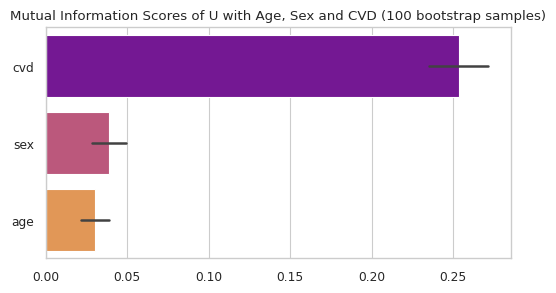

In [ ]:
X = fair_heart_disease[['cvd','age','sex']]
y = fair_heart_disease['U']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50,random_state=i, stratify=fair_heart_disease['U_dim_0'])
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores of U with Age, Sex and CVD (100 bootstrap samples)')
plt.show()

#### Synthetic data alignment
We generate synthetic data from $U$ and compare it with the observed dataset. We explore where the feature distributions deviate from reality and could indicate a misspecification in the model's relationships.

In [12]:
from scipy.stats import norm

np.random.seed(4)

def sample_categorical(probs_matrix):
  return [np.random.choice(len(probs), p=probs) for probs in probs_matrix]


def get_cat_probs(alpha, beta_U, beta_sex, beta_age, U, sex, age):
  logits = [a + b_U*U + b_sex*sex + b_age*age for a, b_U, b_sex, b_age
              in zip(alpha, beta_U, beta_sex, beta_age)]
  logits = np.transpose(np.array(logits))
  return np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

def get_binary_probs(alpha, beta_U, beta_sex, beta_age, U, sex, age):
  logit = alpha + beta_U*U + beta_sex*sex + beta_age*age
  return 1 / (1 + np.exp(-logit))

# SYNTHETIC DATASET reconstructed using inferred parameters and sampled U
synthetic_heart_disease = heart_disease[['age', 'sex', 'cvd']].copy()

# Compute the mean value of U for each individual in the dataset
mean_U = fair_heart_disease.groupby('U_dim_0')['U'].mean()
synthetic_heart_disease['U'] = synthetic_heart_disease.index.map(lambda x: mean_U[x])


#ECG
ecg_probs = get_cat_probs(alpha_ecg, beta_U_ecg, beta_sex_ecg, beta_age_ecg,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
synthetic_heart_disease['synth_ecg'] = sample_categorical(ecg_probs)

#CP
cp_probs = get_cat_probs(alpha_cp, beta_U_cp, beta_sex_cp, beta_age_cp,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
synthetic_heart_disease['synth_cp'] = sample_categorical(cp_probs)

#SLOPE
slope_probs = get_cat_probs(alpha_slope, beta_U_slope, beta_sex_slope, beta_age_slope,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
synthetic_heart_disease['synth_slope'] = sample_categorical(slope_probs)

#ANG
ang_prob = get_binary_probs(alpha_ang, beta_U_ang, beta_sex_ang, beta_age_ang,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
synthetic_heart_disease['synth_ang'] = np.random.binomial(1, ang_prob)

#FBS
fbs_prob = get_binary_probs(alpha_fbs, beta_U_fbs, beta_sex_fbs, beta_age_fbs,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
synthetic_heart_disease['synth_fbs'] = np.random.binomial(1, fbs_prob)

#BP
mean_bp = alpha_bp + beta_U_bp*synthetic_heart_disease['U']\
              + beta_sex_bp*synthetic_heart_disease['sex']\
              + beta_age_bp*synthetic_heart_disease['age']
synthetic_heart_disease['synth_bp'] = np.random.normal(mean_bp, sigma_bp)


#CHOL
mean_chol = alpha_chol + beta_U_chol*synthetic_heart_disease['U']\
              + beta_sex_chol*synthetic_heart_disease['sex']\
              + beta_age_chol*synthetic_heart_disease['age']
synthetic_heart_disease['synth_chol'] = np.random.normal(mean_chol, sigma_chol)

#MHR
mean_mhr = alpha_mhr + beta_U_mhr*synthetic_heart_disease['U']\
              + beta_sex_mhr*synthetic_heart_disease['sex']\
              + beta_age_mhr*synthetic_heart_disease['age']
synthetic_heart_disease['synth_mhr'] = np.random.normal(mean_mhr, sigma_mhr)

#ST
zero_st_prob = get_binary_probs(alpha_zero_st, beta_U_zero_st, beta_sex_zero_st, beta_age_zero_st,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
is_zero = np.random.rand(len(synthetic_heart_disease)) < zero_st_prob

mean_st = alpha_st + beta_U_st*synthetic_heart_disease['U']\
          + beta_sex_st*synthetic_heart_disease['sex']\
          + beta_age_st*synthetic_heart_disease['age']
non_zero_st = np.exp(np.random.normal(mean_st, sigma_st))

synthetic_heart_disease['synth_st'] = np.where(is_zero, 0, non_zero_st)

#### Visualising original and synthetic variable distibrutions

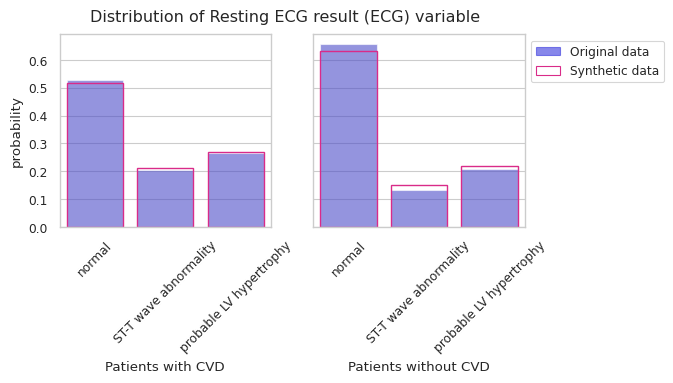

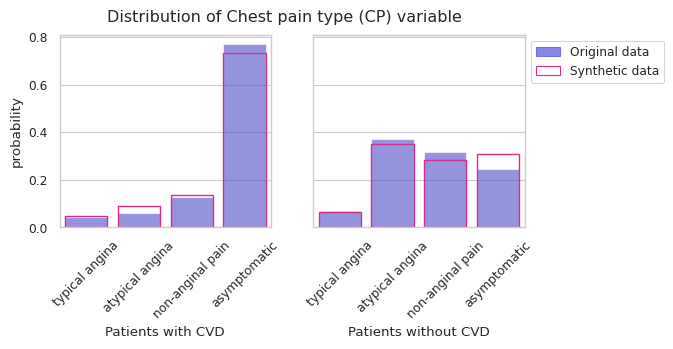

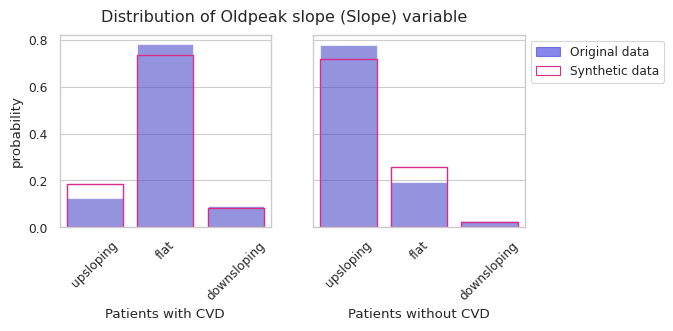

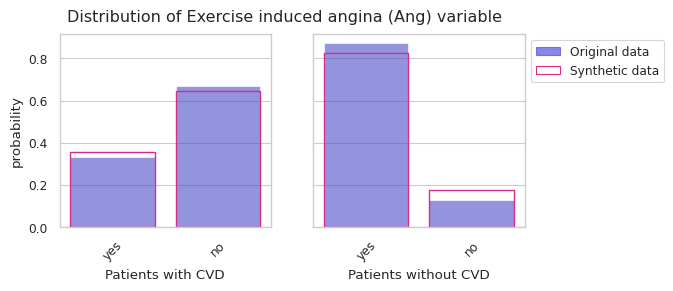

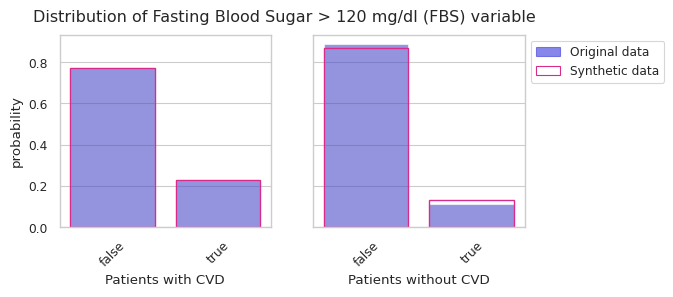

In [11]:
import matplotlib.patches as mpatches
original_c = '#3838DD'
synthetic_c = '#D92B89'
alpha=0.6
original_legend = mpatches.Patch(color=original_c, label='Original data', alpha=alpha)
synthetic_legend = mpatches.Patch(edgecolor=synthetic_c, fill=False,label='Synthetic data')

# Alignment of synthetic categorical and binary variables
def plot_cat_dist_comparison(dataset, data1, data2, label, xticks=[]):
  fig, axes = plt.subplots(1,2, figsize=(6, 2.5), sharey=True)
  sns.countplot(heart_disease[heart_disease['cvd'] == 1], x=data1, color=original_c, stat='probability',ax=axes[0], alpha=alpha)
  sns.countplot(synthetic_heart_disease[synthetic_heart_disease['cvd'] == 1], x=data2, edgecolor=synthetic_c, linewidth=1, fill=False, stat='probability', ax=axes[0])
  sns.countplot(heart_disease[heart_disease['cvd'] == 0], x=data1, color=original_c, stat='probability',ax=axes[1], alpha=alpha)
  sns.countplot(synthetic_heart_disease[synthetic_heart_disease['cvd'] == 0], x=data2, edgecolor=synthetic_c, linewidth=1, fill=False, stat='probability',ax=axes[1])
  axes[1].legend(handles=[original_legend, synthetic_legend], loc='upper left', bbox_to_anchor=(1,1))
  axes[0].set_xlabel('Patients with CVD')
  axes[1].set_xlabel('Patients without CVD')
  axes[0].set_xticks(axes[0].get_xticks(), xticks, rotation=45)
  axes[1].set_xticks(axes[1].get_xticks(), xticks, rotation=45)
  plt.suptitle(f'Distribution of {label} variable')
  plt.show()

plot_cat_dist_comparison('ecg', 'synth_ecg', 'Resting ECG result (ECG)', xticks=['normal','ST-T wave abnormality','probable LV hypertrophy'])
plot_cat_dist_comparison('cp', 'synth_cp', 'Chest pain type (CP)', xticks=['typical angina','atypical angina','non-anginal pain','asymptomatic'])
plot_cat_dist_comparison('slope', 'synth_slope', 'Oldpeak slope (Slope)', xticks=['upsloping','flat','downsloping'])
plot_cat_dist_comparison('ang', 'synth_ang', 'Exercise induced angina (Ang)', xticks=['yes', 'no'])
plot_cat_dist_comparison('fbs', 'synth_fbs', 'Fasting Blood Sugar > 120 mg/dl (FBS)', xticks=['false', 'true'])

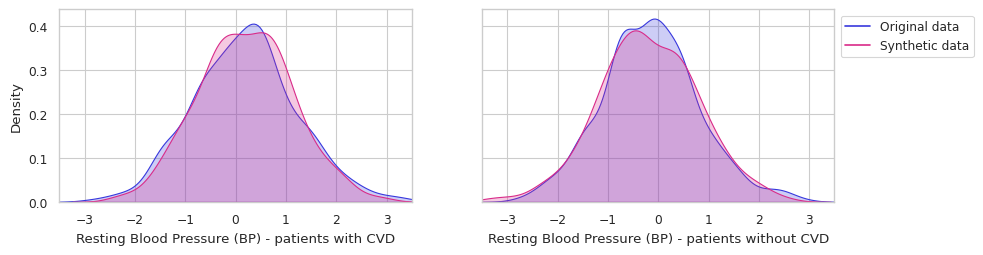

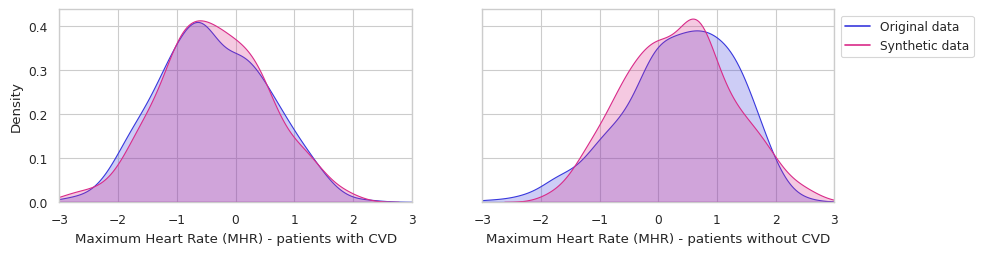

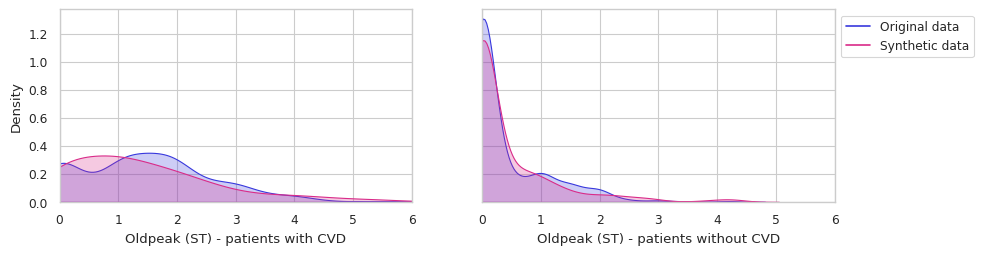

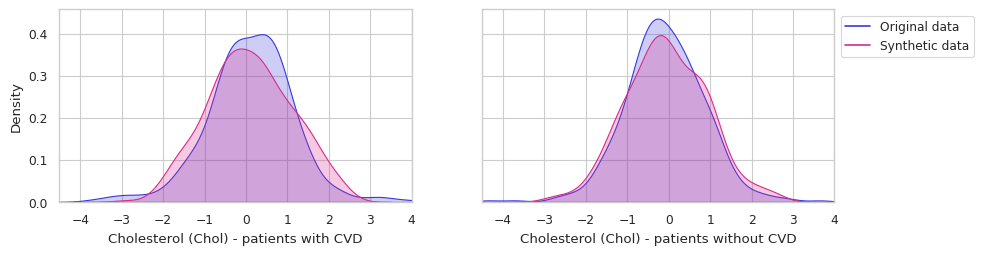

In [ ]:
import matplotlib.lines as mlines
original_legend = mlines.Line2D([], [], color=original_c, label='Original data')
synthetic_legend = mlines.Line2D([], [], color=synthetic_c, label='Synthetic data')

def plot_density_comparison(data1, data2, label, xmin, xmax):
  fig, axes = plt.subplots(1,2, figsize=(10, 2.5), sharey=True)
  axes[1].legend(handles=[original_legend, synthetic_legend], loc='upper left', bbox_to_anchor=(1,1))
  sns.kdeplot(heart_disease[heart_disease['cvd'] == 1], x=data1, fill=True, ax=axes[0], color=original_c)
  sns.kdeplot(synthetic_heart_disease[synthetic_heart_disease['cvd'] == 1], x=data2, fill=True, ax=axes[0], color=synthetic_c)
  sns.kdeplot(heart_disease[heart_disease['cvd'] == 0], x=data1, fill=True, ax=axes[1], color=original_c)
  sns.kdeplot(synthetic_heart_disease[synthetic_heart_disease['cvd'] == 0], x=data2, fill=True, ax=axes[1], color=synthetic_c)
  axes[0].set_xlabel(f'{label} - patients with CVD')
  axes[1].set_xlabel(f'{label} - patients without CVD')
  axes[0].set_xlim(xmin,xmax)
  axes[1].set_xlim(xmin,xmax)
  plt.show()
  return

# Alignment of synthetic continuous variables
plot_density_comparison('bp_scaled', 'synth_bp', 'Resting Blood Pressure (BP)', -3.5,3.5)
plot_density_comparison('mhr', 'synth_mhr', 'Maximum Heart Rate (MHR)', -3,3)
plot_density_comparison('st', 'synth_st', 'Oldpeak (ST)', 0, 6)
plot_density_comparison('chol_scaled', 'synth_chol', 'Cholesterol (Chol)', -4.5, 4)

#### Bias pathways
We analyse the parameters of the model to validate that the variables treated as sex-biased indeed have a strong causal link with the protected attribute.

### Counterfactual dataset

In [25]:
# SYNTHETIC DATASET reconstructed using inferred parameters and sampled U
cf_heart_disease = heart_disease.copy()

# Compute the mean value of U for each individual in the dataset
mean_U = fair_heart_disease.groupby('U_dim_0')['U'].mean()
cf_heart_disease['U'] = cf_heart_disease.index.map(lambda x: mean_U[x])
cf_heart_disease['sex'] = 1 - cf_heart_disease['sex']

#ECG
ecg_probs = get_cat_probs(alpha_ecg, beta_U_ecg, beta_sex_ecg, beta_age_ecg,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])
cf_heart_disease['ecg'] = np.argmax(ecg_probs, axis=1)

#CP
cp_probs = get_cat_probs(alpha_cp, beta_U_cp, beta_sex_cp, beta_age_cp,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])
cf_heart_disease['cp'] = np.argmax(cp_probs, axis=1)

#SLOPE
slope_probs = get_cat_probs(alpha_slope, beta_U_slope, beta_sex_slope, beta_age_slope,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])
cf_heart_disease['slope'] = np.argmax(slope_probs, axis=1)

#ANG
ang_prob = get_binary_probs(alpha_ang, beta_U_ang, beta_sex_ang, beta_age_ang,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])
cf_heart_disease['ang'] = (ang_prob > 0.5).astype(int)

#FBS
fbs_prob = get_binary_probs(alpha_fbs, beta_U_fbs, beta_sex_fbs, beta_age_fbs,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])
cf_heart_disease['fbs'] = (fbs_prob > 0.5).astype(int)

#BP
cf_heart_disease['bp_scaled'] = alpha_bp + beta_U_bp*cf_heart_disease['U']\
              + beta_sex_bp*cf_heart_disease['sex']\
              + beta_age_bp*cf_heart_disease['age']


#CHOL
cf_heart_disease['chol_scaled'] = alpha_chol + beta_U_chol*cf_heart_disease['U']\
              + beta_sex_chol*cf_heart_disease['sex']\
              + beta_age_chol*cf_heart_disease['age']

#MHR
cf_heart_disease['mhr'] = alpha_mhr + beta_U_mhr*cf_heart_disease['U']\
              + beta_sex_mhr*cf_heart_disease['sex']\
              + beta_age_mhr*cf_heart_disease['age']

#ST
zero_st_prob = get_binary_probs(alpha_zero_st, beta_U_zero_st, beta_sex_zero_st, beta_age_zero_st,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])

mean_st = alpha_st + beta_U_st*cf_heart_disease['U']\
          + beta_sex_st*cf_heart_disease['sex']\
          + beta_age_st*cf_heart_disease['age']
non_zero_st = np.exp(mean_st + (sigma_st**2/2))

cf_heart_disease['st'] = (1 - zero_st_prob)*non_zero_st


## Predictive models

### Model training

In [26]:
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import barnard_exact

# baseline features and target class

X = heart_disease.drop(['cvd', 'bp', 'chol'], axis=1)
y = heart_disease['cvd']
X_cf = cf_heart_disease.drop(['cvd','U', 'bp', 'chol'], axis=1)
y_cf = cf_heart_disease['cvd']

# Bootstrapping approach with N_RUNS runs and a 70/30 split for training and test
N_RUNS = 50

sss = StratifiedShuffleSplit(n_splits=N_RUNS, test_size=0.3, random_state=42)

perf_metrics = []

for i, (train_index, test_index) in tqdm(enumerate(sss.split(X, y)), total=N_RUNS, desc="Running simulations"):

  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # Create the equivalent fair training and test sets
  fair_X_train = fair_heart_disease.loc[fair_heart_disease['U_dim_0'].isin(train_index),
                                        ['U','age']]
  fair_X_test = fair_heart_disease.loc[fair_heart_disease['U_dim_0'].isin(test_index),
                                       ['U','age']]
  fair_y_train = fair_heart_disease.loc[fair_heart_disease['U_dim_0'].isin(train_index), 'cvd']
  fair_y_test = fair_heart_disease.loc[fair_heart_disease['U_dim_0'].isin(test_index), 'cvd']

  # Train the baseline and fair models
  rf, y_pred, y_pred_proba = train_random_forest(X_train, y_train, X_test, y_test)
  fair_rf, fair_y_pred, fair_y_pred_proba = train_random_forest(fair_X_train, fair_y_train, fair_X_test, fair_y_test)

  #measure global performance metrics
  accuracy, roc_auc, FNR, FPR,*_ = get_perf_metrics(y_test, y_pred, y_pred_proba)
  fair_accuracy, fair_roc_auc, fair_FNR, fair_FPR,*_ = get_perf_metrics(fair_y_test, fair_y_pred, fair_y_pred_proba)

  #### COUNTERFACTUAL TEST
  X_cf_test = X_cf.iloc[test_index]
  y_cf_test = y_cf.iloc[test_index]

  y_cf_pred = rf.predict(X_cf_test)

  # Baseline audit dataset
  baseline_audit_df = X_test.copy()
  baseline_audit_df['y_true'] = y_test
  baseline_audit_df['y_pred'] = y_pred
  baseline_audit_df['y_pred_proba'] = y_pred_proba
  baseline_audit_df['y_cf_pred'] = y_cf_pred

  baseline_male_df = baseline_audit_df[baseline_audit_df['sex'] == 1]
  baseline_female_df = baseline_audit_df[baseline_audit_df['sex'] == 0]

  # Frequency of male individuals with a counterfactually flipped prediction
  # from y=0 to y=1
  flipped_pos_m = len((baseline_male_df['y_true'] == 0) & (baseline_male_df['y_cf_pred'] == 1)) / len(baseline_male_df)

  # Frequency of male individuals with a counterfactually flipped prediction
  # from y=1 to y=0
  flipped_neg_m = len((baseline_male_df['y_true'] == 1) & (baseline_male_df['y_cf_pred'] == 0)) / len(baseline_male_df)

  # Frequency of male individuals with a counterfactually flipped prediction
  # from y=0 to y=1
  flipped_pos_f = len((baseline_female_df['y_true'] == 0) & (baseline_female_df['y_cf_pred'] == 1)) / len(baseline_female_df)

  # Frequency of male individuals with a counterfactually flipped prediction
  # from y=1 to y=0
  flipped_neg_f = len((baseline_female_df['y_true'] == 1) & (baseline_female_df['y_cf_pred'] == 0)) / len(baseline_female_df)



  #### STRATIFIED PERFORMANCE AUDIT

  # Fair audit dataset
  fair_audit_df = fair_heart_disease.loc[fair_heart_disease['U_dim_0'].isin(test_index),
                                       ['U','age','sex']].copy()
  fair_audit_df['y_true'] = fair_y_test
  fair_audit_df['y_pred'] = fair_y_pred
  fair_audit_df['y_pred_proba'] = fair_y_pred_proba
  fair_male_df = fair_audit_df[fair_audit_df['sex'] == 1]
  fair_female_df = fair_audit_df[fair_audit_df['sex'] == 0]

  accuracy_m, roc_auc_m, FNR_m, FPR_m, tn_m, fp_m, fn_m, tp_m = get_perf_metrics(
      baseline_male_df['y_true'],
      baseline_male_df['y_pred'],
      baseline_male_df['y_pred_proba'])

  accuracy_f, roc_auc_f, FNR_f, FPR_f, tn_f, fp_f, fn_f, tp_f = get_perf_metrics(
      baseline_female_df['y_true'],
      baseline_female_df['y_pred'],
      baseline_female_df['y_pred_proba'])

  fair_accuracy_m, fair_roc_auc_m, fair_FNR_m, fair_FPR_m, *_ = get_perf_metrics(
      fair_male_df['y_true'],
      fair_male_df['y_pred'],
      fair_male_df['y_pred_proba'])

  fair_accuracy_f, fair_roc_auc_f, fair_FNR_f, fair_FPR_f, *_ = get_perf_metrics(
      fair_female_df['y_true'],
      fair_female_df['y_pred'],
      fair_female_df['y_pred_proba'])

  perf_metrics.append({
      'run': i,
      'accuracy': accuracy,
      'roc_auc': roc_auc,
      'FNR': FNR,
      'FPR': FPR,
      'fair_accuracy': fair_accuracy,
      'fair_roc_auc': fair_roc_auc,
      'fair_FNR': fair_FNR,
      'fair_FPR': fair_FPR,
      'accuracy_m': accuracy_m,
      'accuracy_f': accuracy_f,
      'roc_auc_m': roc_auc_m,
      'roc_auc_f': roc_auc_f,
      'FNR_m': FNR_m,
      'FNR_f': FNR_f,
      'FPR_m': FPR_m,
      'FPR_f': FPR_f,
      'fair_accuracy_m': fair_accuracy_m,
      'fair_accuracy_f': fair_accuracy_f,
      'fair_roc_auc_m': fair_roc_auc_m,
      'fair_roc_auc_f': fair_roc_auc_f,
      'fair_FNR_m': fair_FNR_m,
      'fair_FNR_f': fair_FNR_f,
      'fair_FPR_m': fair_FPR_m,
      'fair_FPR_f': fair_FPR_f,
      'accuracy_diff': accuracy_m - accuracy_f,
      'roc_auc_diff': roc_auc_m - roc_auc_f,
      'FNR_diff': FNR_m - FNR_f,
      'FPR_diff': FPR_m - FPR_f,
      'fair_accuracy_diff': fair_accuracy_m - fair_accuracy_f,
      'fair_roc_auc_diff': fair_roc_auc_m - fair_roc_auc_f,
      'fair_FNR_diff': fair_FNR_m - fair_FNR_f,
      'fair_FPR_diff': fair_FPR_m - fair_FPR_f,
      'flipped_pos_m': flipped_pos_m,
      'flipped_neg_m': flipped_neg_m,
      'flipped_pos_f': flipped_pos_f,
      'flipped_neg_f': flipped_neg_f
  })


Running simulations: 100%|██████████| 50/50 [23:10<00:00, 27.81s/it]


In [27]:
import os
import datetime
save_path = f'{PROJECT_ROOT}/counterfactual-fairness/results'
os.makedirs(save_path, exist_ok=True)

perf_metrics_df = pd.DataFrame(perf_metrics)
date_str = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
perf_metrics_df.to_csv(f'{save_path}/perf_metrics_{N_RUNS}_runs_{date_str}_50samples.csv')
print('Performance metrics saved')

Performance metrics saved


### Results

In [ ]:
N_RUNS = 50
# perf_metrics_df = pd.read_csv(f'{PROJECT_ROOT}/counterfactual-fairness/results/perf_metrics_{N_RUNS}_runs.csv')


# BASELINE PERFORMANCE
accuracy_ci = get_95_ci(perf_metrics_df['accuracy'])
roc_auc_ci = get_95_ci(perf_metrics_df['roc_auc'])
fnr_ci = get_95_ci(perf_metrics_df['FNR'])
fpr_ci = get_95_ci(perf_metrics_df['FPR'])

# FAIR PERFORMANCE
fair_accuracy_ci = get_95_ci(perf_metrics_df['fair_accuracy'])
fair_roc_auc_ci = get_95_ci(perf_metrics_df['fair_roc_auc'])
fair_fnr_ci = get_95_ci(perf_metrics_df['fair_FNR'])
fair_fpr_ci = get_95_ci(perf_metrics_df['fair_FPR'])

perf_summary = pd.DataFrame({
    'Model': ['Baseline', 'Fair'],
    'Accuracy': [perf_metrics_df['accuracy'].mean(),
                 perf_metrics_df['fair_accuracy'].mean()],
    'Acc. 95% CI': [f'{round(accuracy_ci[0], 3)}-{round(accuracy_ci[1], 3)}',
                    f'{round(fair_accuracy_ci[0], 3)}-{round(fair_accuracy_ci[1], 3)}'],
    'ROC AUC': [perf_metrics_df['roc_auc'].mean(),
                perf_metrics_df['fair_roc_auc'].mean()],
    'ROC AUC 95% CI': [f'{round(roc_auc_ci[0], 3)}-{round(roc_auc_ci[1], 3)}',
                       f'{round(fair_roc_auc_ci[0], 3)}-{round(fair_roc_auc_ci[1], 3)}'],
    'FNR': [perf_metrics_df['FNR'].mean(),
             perf_metrics_df['fair_FNR'].mean()],
    'FNR 95% CI': [f'{round(fnr_ci[0], 3)}-{round(fnr_ci[1], 3)}',
                    f'{round(fair_fnr_ci[0], 3)}-{round(fair_fnr_ci[1], 3)}'],
    'FPR': [perf_metrics_df['FPR'].mean(),
             perf_metrics_df['fair_FPR'].mean()],
    'FPR 95% CI': [f'{round(fpr_ci[0], 3)}-{round(fpr_ci[1], 3)}',
                    f'{round(fair_fpr_ci[0], 3)}-{round(fair_fpr_ci[1], 3)}']
})

print(perf_summary.to_markdown(index=False, numalign="right"))


| Model    |   Accuracy | Acc. 95% CI   |   ROC AUC | ROC AUC 95% CI   |      FNR | FNR 95% CI   |      FPR | FPR 95% CI   |
|:---------|-----------:|:--------------|----------:|:-----------------|---------:|:-------------|---------:|:-------------|
| Baseline |   0.860804 | 0.855-0.866   |  0.925693 | 0.922-0.93       |  0.13514 | 0.126-0.144  | 0.142906 | 0.133-0.153  |
| Fair     |    0.79104 | 0.787-0.795   |  0.863308 | 0.859-0.868      | 0.216093 | 0.21-0.223   | 0.202436 | 0.194-0.211  |


In [ ]:
from scipy.stats import ttest_rel

# Statistical significance of the difference in FNR disparity
fnr_fair_ttest = ttest_rel(perf_metrics_df['fair_FNR_diff'],
                           perf_metrics_df['FNR_diff'],
                           alternative='greater')
print("FNR DISPARITY BETWEEN MALE AND FEMALE PATIENTS")
print(f"Average FNR Disparity in the baseline model:\
 {perf_metrics_df['FNR_diff'].mean()*100:.2f}%")
print(f"Std Dev FNR Disparity in the baseline model:\
 {perf_metrics_df['FNR_diff'].std()*100:.2f}%")
print('-'*20)
print(f"Average FNR Disparity in the fair model:\
 {perf_metrics_df['fair_FNR_diff'].mean()*100:.2f}%")
print(f"Std Dev FNR Disparity in the fair model:\
 {perf_metrics_df['fair_FNR_diff'].std()*100:.2f}%")
print('-'*20)
print(f"Paired T-Statistic (t): {fnr_fair_ttest.statistic:.4f}")
print(f"P-value: {fnr_fair_ttest.pvalue:.6f}")


FNR DISPARITY BETWEEN MALE AND FEMALE PATIENTS
Average FNR Disparity in the baseline model: -10.09%
Std Dev FNR Disparity in the baseline model: 13.44%
--------------------
Average FNR Disparity in the fair model: 2.36%
Std Dev FNR Disparity in the fair model: 8.70%
--------------------
Paired T-Statistic (t): 9.8219
P-value: 0.000000


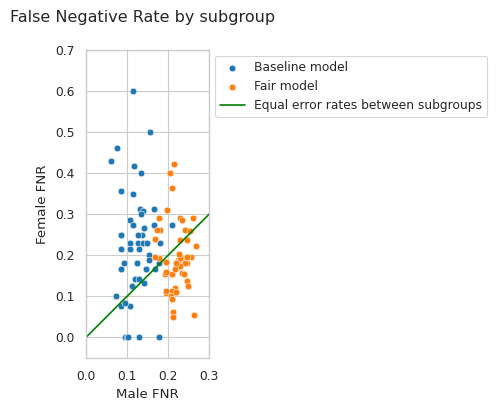

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(perf_metrics_df, x='FNR_m', y='FNR_f', ax=ax, c='#1f77b4')
sns.scatterplot(perf_metrics_df, x='fair_FNR_m', y='fair_FNR_f', ax=ax, c='#ff7f0e')
plt.plot([0,.7],[0,.7],c='g')
fig.suptitle('False Negative Rate by subgroup')
plt.xlabel('Male FNR')
plt.ylabel('Female FNR')
plt.legend(labels=['Baseline model', 'Fair model', 'Equal error rates between subgroups'], loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlim([0,0.3])
ax.set_ylim([-.05,0.7])
ax.set_aspect('equal')
plt.show()

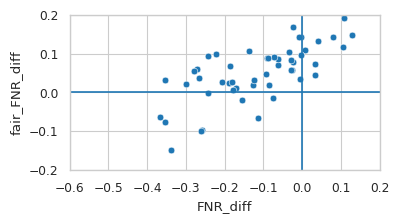

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(perf_metrics_df, x='FNR_diff', y='fair_FNR_diff')
plt.axhline(y=0)
plt.axvline(x=0)
ax.set_xlim([-.6,0.2])
ax.set_ylim([-.2,0.2])
ax.set_aspect('equal')
plt.show()